# Task 3: Image Super-resolution

### Submission By: [Saurabh Johri](mailto:saurabhxj@gmail.com)

### 3B Task Description
Train a deep learning-based super-resolution algorithm of your choice to enhance low-resolution strong lensing images using a limited dataset of real HR/LR pairs collected from HSC and HST telescopes. You can adapt and fine-tune your super-resolution model from Task III.A. or use any other approach, such as few-shot learning strategies, transfer learning, domain adaptation, or data augmentation techniques, etc. Please implement your approach in PyTorch or Keras and discuss your strategy.

### Dataset
The dataset comprises 300 strong lensing image pairs at multiple resolutions: high-resolution (HR) and low-resolution (LR).

- There are 300 image pairs (low-res, high-res) in total.
- The low resolution images are one channel and have the dimensions (64x64) pixels
- The high resolution images are also one channel and have the dimensions (128x128)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash

unzip -q /content/drive/MyDrive/DeepLenseGSOC/Task3/Dataset3B.zip -d /content/

## Proposed Strategy

- Use transfer learning on the model trained for Task 3A and fine-tune it for the new dataset.
- The base model architecture is detailed in Enhanced Deep Residual Networks for Single Image Super-Resolution by [Bee Lim et al.](https://arxiv.org/abs/1707.02921)
- Use a GPU to accelerate the training process (NVIDIA T4 in this case, through Google Colab)
- Load and the images in *'.npy'* (numpy array) format using PIL (Pillow) library and create a Tensorflow Dataset for model training.
- Start without any data augmentation or any manipulations to establish a baseline and iterate with different techniques one-by-one if necessary.
- Use the entire dataset for training due to very limited amount of data available.

In [ ]:
import os

import tensorflow as tf
import numpy as np
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import sklearn
from PIL import Image
import cv2
from glob import glob
from tqdm import tqdm
import gc
gc.enable()

%matplotlib inline

PATH = '/content/Dataset'
IMAGE_PATH  = '/content/image_dataset'
BATCH_SIZE = 1
RANDOM_SEED = 42

keras.utils.set_random_seed(RANDOM_SEED)

### Create utilities to process images

- Since the base architecture in the aforementioned paper uses 3 channel images, expand the image dimensions to 3 channels with all 3 channels being identical to each other.
- Using numpy to read the image arrays and PIL to convert them to a PIL image.
- Resizing the low-res images from (64x64) to (75x75) in order to match the expected dimensions by the model.
- Same process for high-res images, converting (128x128) images to (150x150).

In [ ]:
def load_image(file_path):
    arr = np.load(file_path)
    arr = np.moveaxis(arr, 0, -1)
    arr = np.dstack([arr, arr, arr])
    im = Image.fromarray((arr * 255).astype(np.uint8))
    return im

hr_folder = f'{PATH}/HR'
lr_folder = f'{PATH}/LR'

num_images = len(os.listdir(lr_folder))

# both low resolution and high resolution images have the same filename
# using the common file name, load the image pairs and return them
# used to map to a dataset of filenames later
# also resizing the images here to match the expected dimensions by the model
def load_image_pair(image_path):
    image_path = image_path.decode('utf-8')
    lr_path, hr_path = image_path, image_path.replace('LR', 'HR')
    lr_image = load_image(lr_path).resize((75, 75))
    hr_image = load_image(hr_path).resize((150, 150))
    return lr_image, hr_image

dataset = tf.data.Dataset.list_files(f'{PATH}/LR/*.npy')
dataset = dataset.map(lambda image_path: tf.numpy_function(load_image_pair, [image_path], [tf.uint8, tf.uint8]), num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.shuffle(num_images).batch(BATCH_SIZE)

### Create model
- The model will be identical to the one in Task 3A.
- Using all layers in the pretrained model except the last few as the base for transfer learning.
- Creating new final layers for image superresolution and freezing the base model weights for initial training.
- After loss convergence, unfreezing all the weights and fine-tuning the model using a very low learning rate for further improvements.

In [ ]:
# residual block
def residual_block(inputs, num_filters=64):
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x

def make_model(num_filters, num_residual=8, factor=2):
    input_layer = layers.Input(shape=(75, 75, 3))

    # scale pixel values to between 0 and 1
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # create num_residual Residual Blocks
    for _ in range(num_residual):
        x_new = residual_block(x_new, num_filters)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = layers.Conv2D(num_filters * (factor ** 2), 3, padding="same")(x)

    # upscale the image to the appropriate dimensions of the target image
    # in this case, by a factor of 2
    x = tf.nn.depth_to_space(x, block_size=factor)

    base_model = keras.Model(input_layer, x)

    x = layers.Conv2D(3, 3, padding="same")(x)

    # rescale the images back to 0-255 range
    output_layer = layers.Rescaling(scale=255)(x)
    return base_model, keras.Model(input_layer, output_layer)

base_model, model = make_model(num_filters=32, num_residual=8)

### Loading the pretrained weights
- Using the saved weights from the previous model to initialize the base model.

In [ ]:
model.load_weights('/content/drive/MyDrive/DeepLenseGSOC/Task3/task_3a.h5')

### Check if the weights have been loaded properly

- The following code should raise an error if the model weights are not within tolerance limits.

In [ ]:
np.testing.assert_allclose(model.layers[-4].get_weights()[0], base_model.layers[-2].get_weights()[0])

### Define the additional loss functions

- Creating loss functions to represent PSNR (peak signal-to-noise ratio) and SSIM (structural similartity index).
- A PSNR of above 40 dB is generally considered a good value for a reconstruction.
- A SSIM of 1 indicates a perfect reconstruction.

In [ ]:
def PSNR(high_resolution, super_resolution):
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

def SSIM(high_resolution, super_resolution):
    ssim_value = tf.image.ssim(high_resolution, super_resolution, max_val=255)[0]
    return ssim_value

### Configuring model for initial training
- Set the base model to not be trainable initially.
- Create a new model using the base_model as the backbone with new convolutional layer on top.

In [ ]:
base_model.trainable = False

inputs = layers.Input(shape=(75, 75, 3))
x = base_model(inputs, training=False)
x = layers.Conv2D(3, 3, padding="same")(x)
outputs = layers.Rescaling(scale=255)(x)
new_model = keras.Model(inputs, outputs)

In [ ]:
new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 model (Functional)          (None, 150, 150, 32)      195104    
                                                                 
 conv2d_20 (Conv2D)          (None, 150, 150, 3)       867       
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
Total params: 195971 (765.51 KB)
Trainable params: 867 (3.39 KB)
Non-trainable params: 195104 (762.12 KB)
_________________________________________________________________


### Define training parameters and fit the model

- Using the Adam optimizer initially with default settings.
- Using early stopping to monitor the model loss and stopping training if the model performance does not improve over 5 epochs.

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)

EPOCHS = 100

new_model.compile(optimizer=keras.optimizers.Adam(), loss="mse", metrics=[PSNR, SSIM])
checkpoint_path = f'/content/drive/MyDrive/DeepLenseGSOC/Task3/task_3b.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='loss', mode='min', verbose=0)

history = new_model.fit(dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[cp_callback, es])

Epoch 1/100
300/300 [==============================] - 9s 12ms/step - loss: 132.6740 - PSNR: 29.5531 - SSIM: 0.6590
Epoch 2/100
300/300 [==============================] - 2s 7ms/step - loss: 113.4600 - PSNR: 30.3718 - SSIM: 0.6655
Epoch 3/100
300/300 [==============================] - 2s 6ms/step - loss: 115.6587 - PSNR: 30.5522 - SSIM: 0.6606
Epoch 4/100
300/300 [==============================] - 2s 6ms/step - loss: 107.0159 - PSNR: 30.9643 - SSIM: 0.7017
Epoch 5/100
300/300 [==============================] - 4s 10ms/step - loss: 108.1382 - PSNR: 31.0615 - SSIM: 0.6958
Epoch 6/100
300/300 [==============================] - 2s 6ms/step - loss: 104.1986 - PSNR: 31.1368 - SSIM: 0.7086
Epoch 7/100
300/300 [==============================] - 2s 6ms/step - loss: 111.2054 - PSNR: 31.3072 - SSIM: 0.7024
Epoch 8/100
300/300 [==============================] - 2s 6ms/step - loss: 106.3818 - PSNR: 31.2054 - SSIM: 0.7384
Epoch 9/100
300/300 [==============================] - 2s 7ms/step - loss: 102

### Fine-tuning the model

- Unfreezing the base model weights.
- Using a very low learning rate of 1e-5 on the Adam optimizer for fine tuning.
- Same early stopping criteria as before.

In [ ]:
base_model.trainable = True
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss="mse", metrics=[PSNR, SSIM])
history = new_model.fit(dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[cp_callback, es])

Epoch 1/100
300/300 [==============================] - 12s 18ms/step - loss: 94.7797 - PSNR: 31.8662 - SSIM: 0.7515
Epoch 2/100
300/300 [==============================] - 4s 12ms/step - loss: 90.5093 - PSNR: 32.0063 - SSIM: 0.7595
Epoch 3/100
300/300 [==============================] - 4s 11ms/step - loss: 90.6650 - PSNR: 32.2109 - SSIM: 0.7673
Epoch 4/100
300/300 [==============================] - 6s 18ms/step - loss: 87.2016 - PSNR: 32.3667 - SSIM: 0.7696
Epoch 5/100
300/300 [==============================] - 4s 11ms/step - loss: 89.6548 - PSNR: 32.3211 - SSIM: 0.7662
Epoch 6/100
300/300 [==============================] - 5s 16ms/step - loss: 84.8620 - PSNR: 32.7033 - SSIM: 0.7818
Epoch 7/100
300/300 [==============================] - 4s 12ms/step - loss: 85.0637 - PSNR: 32.7271 - SSIM: 0.7829
Epoch 8/100
300/300 [==============================] - 5s 14ms/step - loss: 82.7848 - PSNR: 33.0158 - SSIM: 0.7887
Epoch 9/100
300/300 [==============================] - 5s 14ms/step - loss: 83.

### Plotting the model loss over epochs

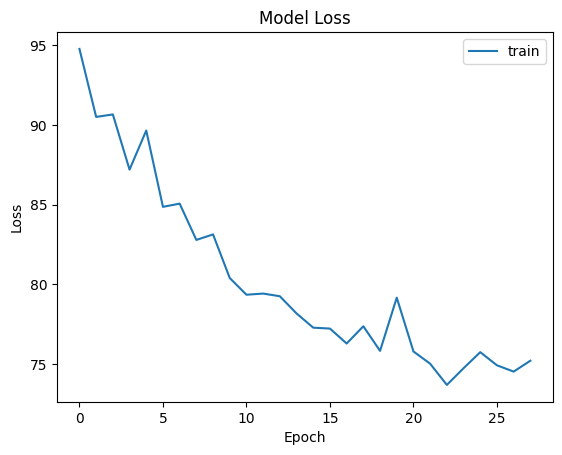

In [ ]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='best')
plt.show()

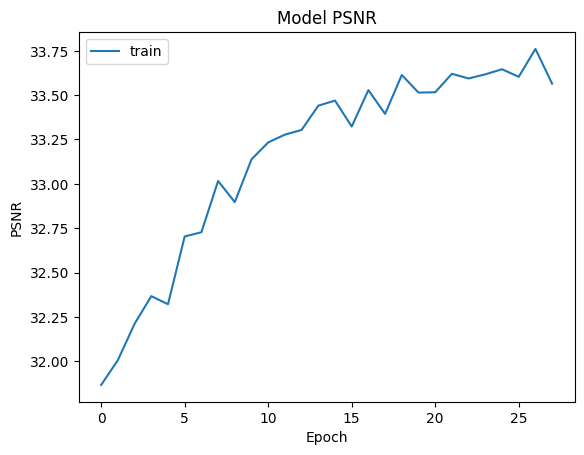

In [ ]:
plt.plot(history.history['PSNR'])
# plt.plot(history.history['val_PSNR'])
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(['train'], loc='best')
plt.show()

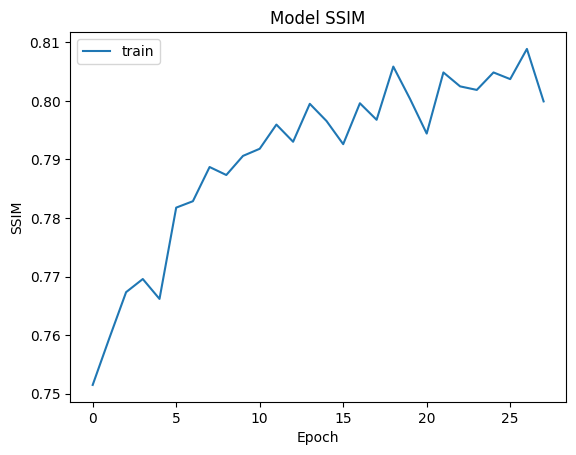

In [ ]:
plt.plot(history.history['SSIM'])
# plt.plot(history.history['val_SSIM'])
plt.title('Model SSIM')
plt.ylabel('SSIM')
plt.xlabel('Epoch')
plt.legend(['train'], loc='best')
plt.show()

### Sample and plot images

- Sampling some images from the dataset and plotting their reconstructions/superresolutions alongside the low-res and high-res versions for qualitative observation.

In [ ]:
def plot_results(lowres, highres, preds):
    plt.figure(figsize=(14, 7))
    plt.subplot(131), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(132), plt.imshow(highres), plt.title("High resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()

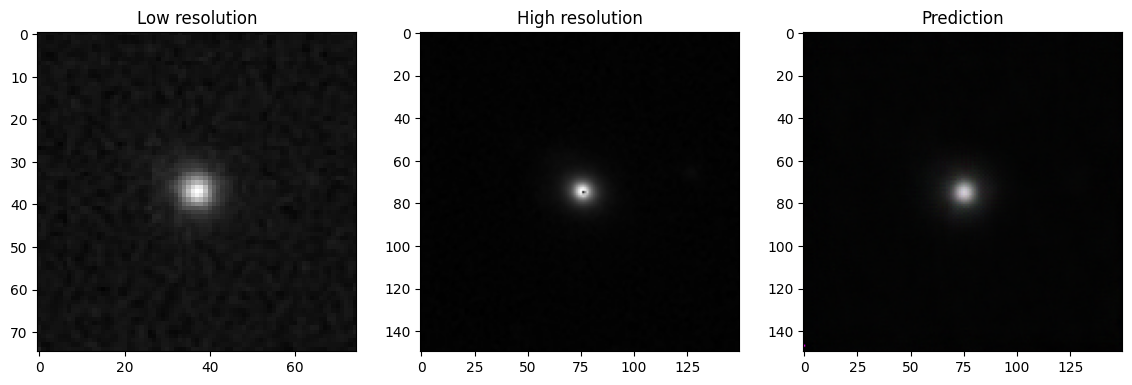

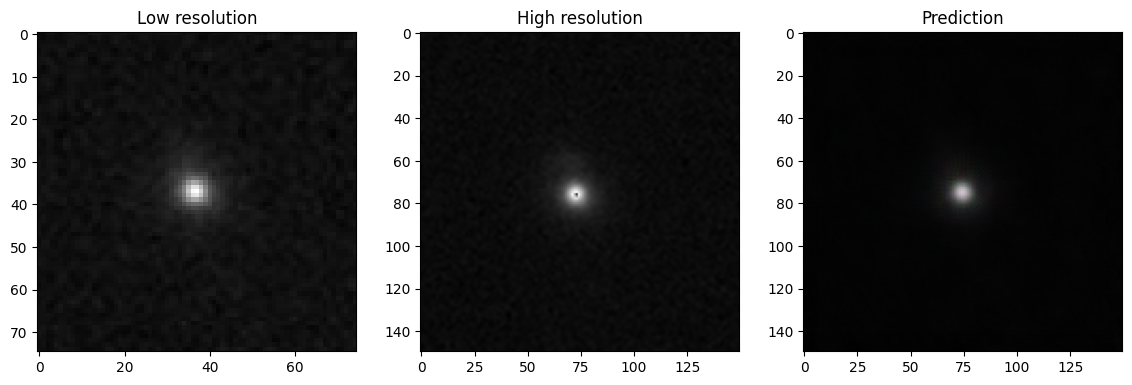

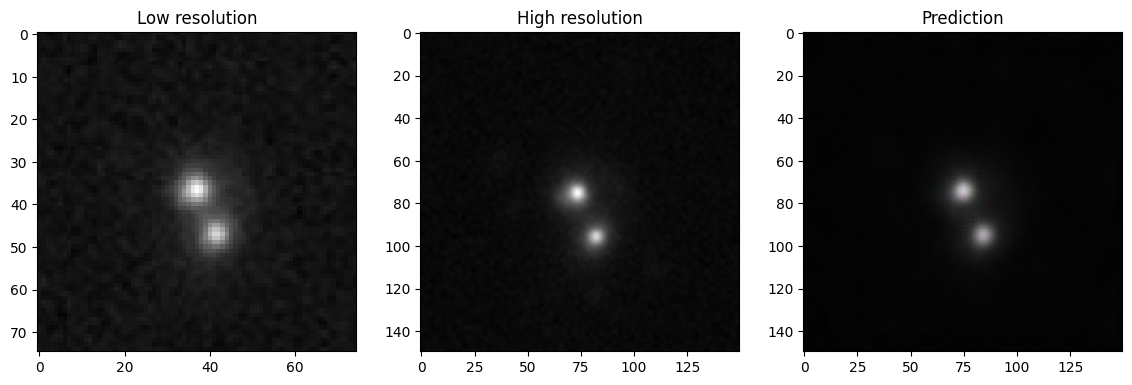

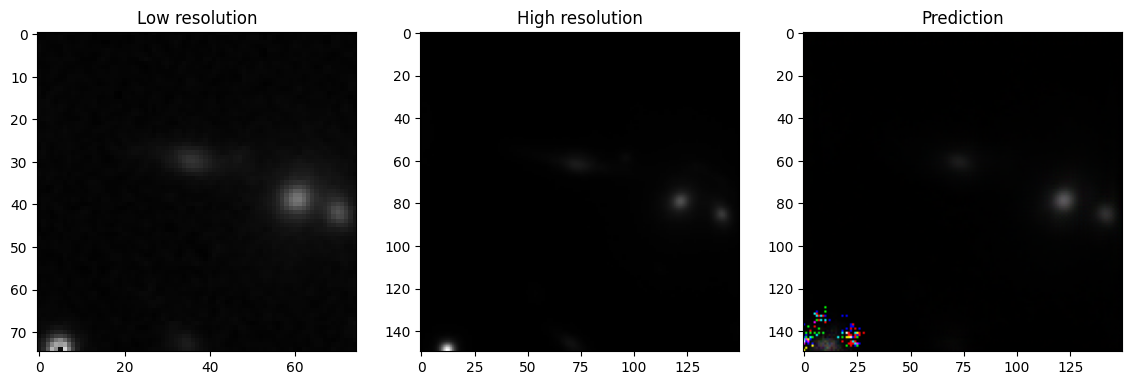

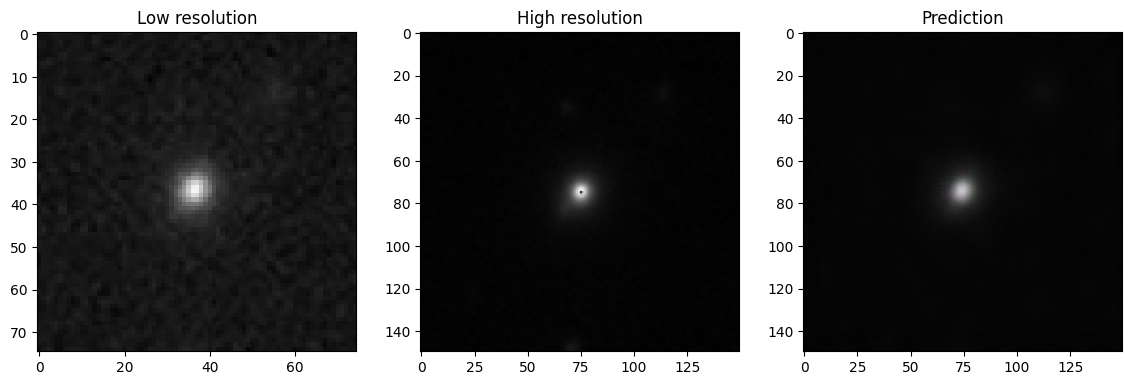

In [ ]:
for lowres, highres in dataset.take(5):
    preds = new_model.predict_step(lowres)
    for i in range(min(BATCH_SIZE, 5)):
      plot_results(lowres[i], highres[i], preds[i].numpy().astype(np.uint8))

### Saving the entire model as an alternative option

In [ ]:
model.save('/content/drive/MyDrive/DeepLenseGSOC/Task3/task_3b_model.keras')

### Observations

- The super-resolution model converges on a MSE (mean-squared error) of around 75.
- The PSNR (peak signal-to-noise ratio) achieved is around 34 dB.
- The SSIM (structural similarity index) achieved is around 0.81.
- The predictions are clearly a step above the low resolution inputs and similar to the high resolution images however they're not as high quality as the reconstructions of the simulated images from the previous task.
- The model is able to create decent reconstructions however in cases where there is minimal information in the low resolution images, the model doesn't perform well.
- Furthermore, in cases where there's artifacting in the low resolution images (very abrubt high-contrast regions) it causes errors in the predictions of the model. Visually, it should be alright to only use one channel image in grayscale since each channel is identical and was only used for training purposes.